In [2]:
import cv2
import numpy as np
import mediapipe as mp
import time
import os
from matplotlib import pyplot as plt

In [3]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [5]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [6]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [7]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = mediapipe_detection(frame, holistic)
        
        draw_styled_landmarks(image, results)

        cv2.imshow("Camera Feed", image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [8]:
results

mediapipe.python.solution_base.SolutionOutputs

In [9]:
draw_styled_landmarks(frame, results)

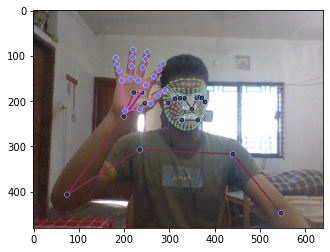

In [10]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [11]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [12]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [13]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [14]:
extract_keypoints(results)

array([ 0.54755175,  0.45488688, -0.6976788 , ...,  0.28506696,
        0.22032298, -0.04041857])

In [15]:
DATA_PATH = os.path.join('MP_Data')
actions = np.array(["hello", "thanks", "i love you"])
no_sequences = 30
sequence_length = 30

In [16]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [19]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                
        
                ret, frame = cap.read()

                image, results = mediapipe_detection(frame, holistic)

                draw_styled_landmarks(image, results)
                
                if frame_num == 0:
                    cv2.putText(image, "Starting Collection", (120,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, "Collecting Frame for {} video number {}".format(action, sequence), (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, "Collecting Frame for {} video number {}".format(action, sequence), (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

                cv2.imshow("Camera Feed", image)
                
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()

In [20]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [21]:
label_map = {label:num for num, label in enumerate(actions)}

In [22]:
label_map

{'hello': 0, 'thanks': 1, 'i love you': 2}

In [24]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [28]:
X = np.array(sequences)

In [29]:
X.shape

(90, 30, 1662)

In [30]:
y = to_categorical(labels).astype(int)

In [31]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)